## Generate Terrain Data

The rest of the geo-related functions focus on raster data (or rasterized data, after a previous Datashader step that returns an Xarray object). To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster:

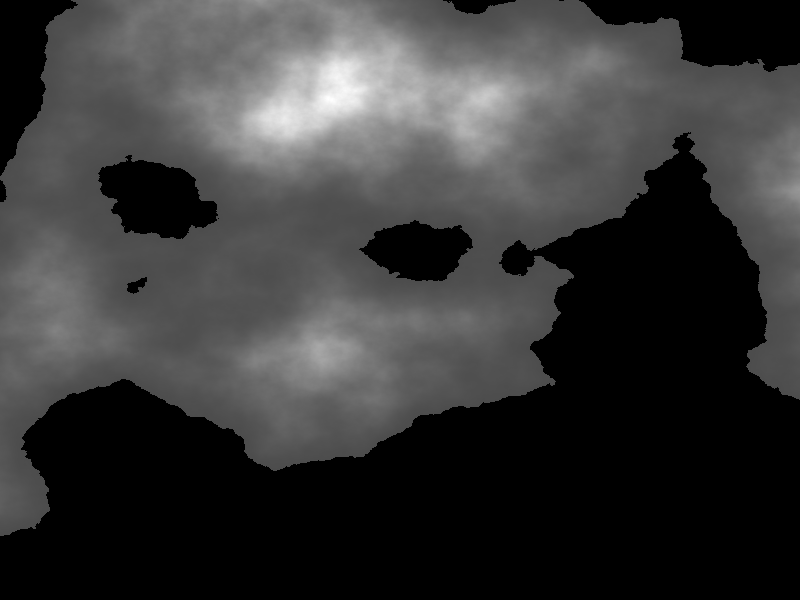

In [3]:
import numpy as np, datashader as ds
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

from xrspatial.terrain import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscale value above shows the elevation linearly in intensity (with the large black areas indicating low elevation), but it will look more like a landscape if we map the lowest values to colors representing water, and the highest to colors representing mountaintops:

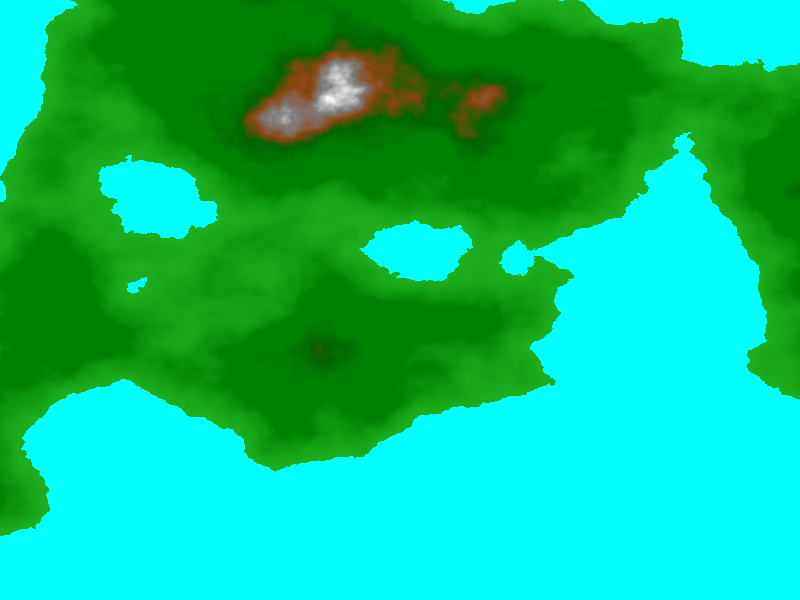

In [6]:
shade(terrain, cmap=Elevation, how='linear')

## Hillshade

[Hillshade](https://en.wikipedia.org/wiki/Terrain_cartography) is a technique used to visualize terrain as shaded relief, illuminating it with a hypothetical light source. The illumination value for each cell is determined by its orientation to the light source, which is based on slope and aspect.

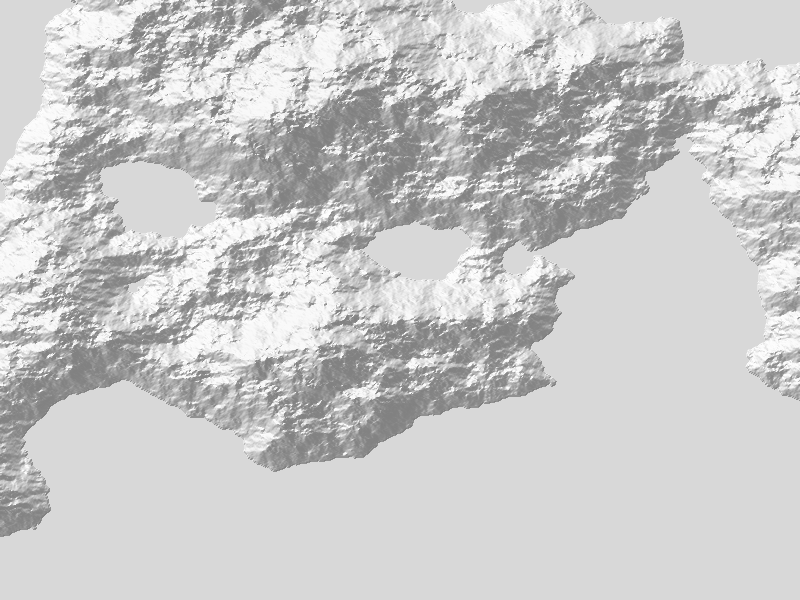

In [4]:
from xrspatial.hillshade import hillshade

illuminated = hillshade(terrain)

shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

You can combine hillshading with elevation colormapping to convey differences in terrain with elevation:

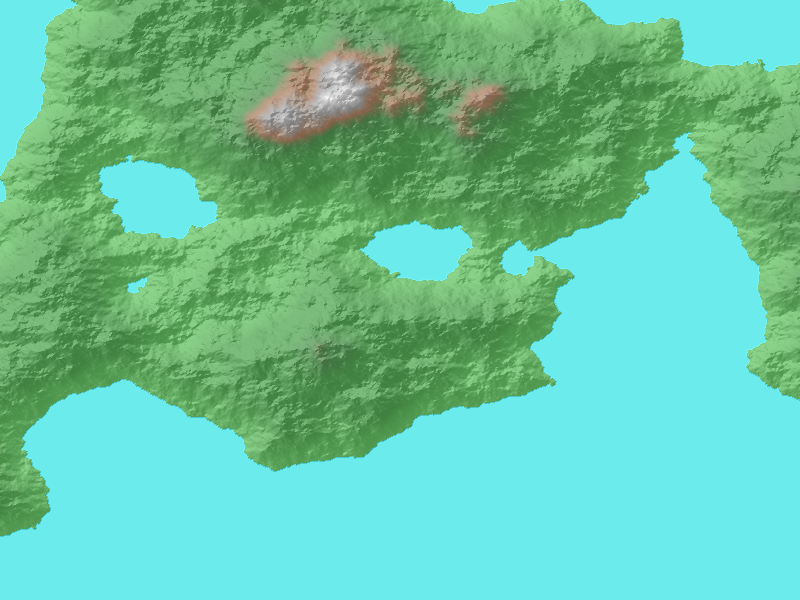

In [5]:
stack(shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(terrain,     cmap=Elevation,         alpha=128, how='linear'))

## Slope
[Slope](https://en.wikipedia.org/wiki/Slope) is the inclination of a surface. 
In geography, *slope* is amount of change in elevation of a terrain regarding its surroundings.

Datashader's slope function returns slope in degrees.  Below we highlight areas at risk for avalanche by looking at [slopes around 38 degrees](http://wenatcheeoutdoors.org/2016/04/07/avalanche-abcs-for-snowshoers/).

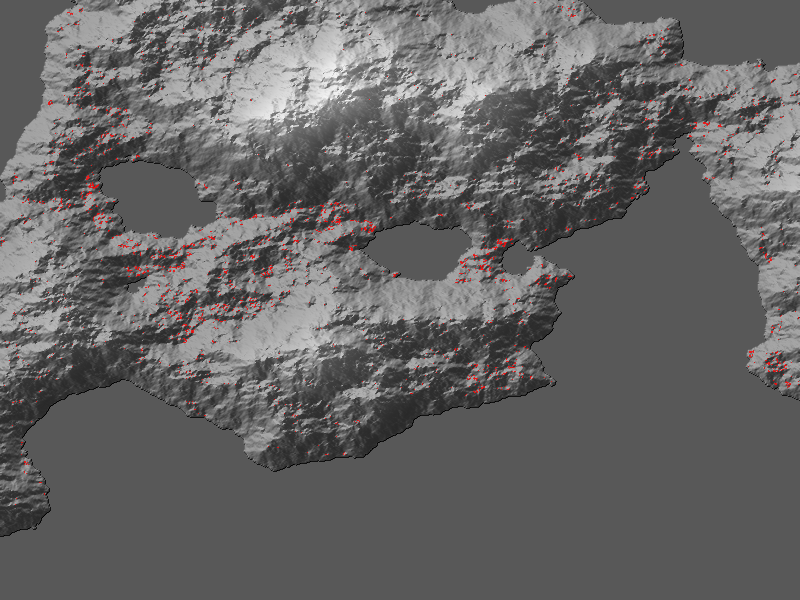

In [6]:
from xrspatial.slope import slope

risky = slope(terrain)
risky.data = np.where(np.logical_and(risky.data > 25, risky.data < 50), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(risky,       cmap='red',              how='linear', alpha=200))

## Aspect

[Aspect](https://en.wikipedia.org/wiki/Aspect_(geography)) is the orientation of slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing.

Below, we look to find slopes that face close to North.

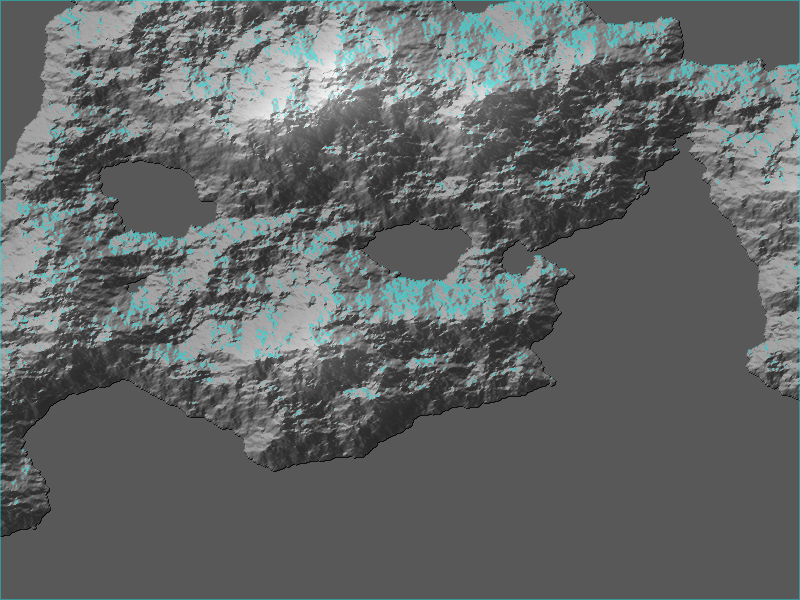

In [7]:
from xrspatial.aspect import aspect

north_faces = aspect(terrain)
north_faces.data = np.where(np.logical_or(north_faces.data > 350 ,
                                          north_faces.data < 10), 1, np.nan)

stack(shade(terrain,     cmap=['black', 'white'], how='linear'),
      shade(illuminated, cmap=['black', 'white'], how='linear', alpha=128),
      shade(north_faces, cmap=['aqua'],           how='linear', alpha=100))

## NDVI

The [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) is a metric designed to detect regions with vegetation by measuring the difference between near-infrared (NIR) light (which vegetation reflects) and red light (which vegetation absorbs).

The NDVI ranges over [-1,+1], where `-1` means more "Red" radiation while `+1` means more "NIR" radiation. NDVI values close to +1.0 suggest areas dense with active green foliage, while strongly negative values suggest cloud cover or snow, and values near zero suggest open water, urban areas, or bare soil. 

For our synthetic example here, we don't have access to NIR measurements, but we can approximate the results for demonstration purposes by using the green and blue channels of a colormapped image, as those represent a difference in wavelength similar to NIR vs. Red.

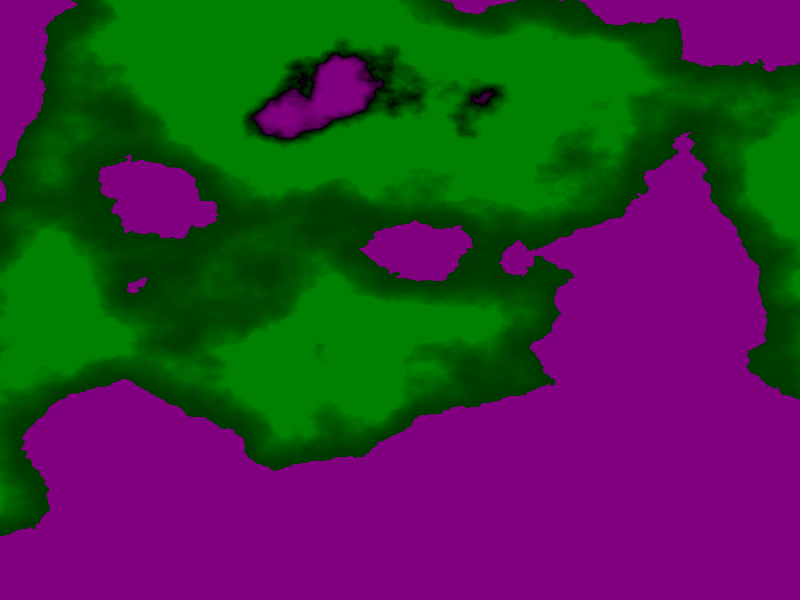

In [9]:
import xarray as xr

from xrspatial.ndvi import ndvi

rgba = stack(shade(terrain, cmap=Elevation, how='linear')).to_pil()
r,g,b,a = [xr.DataArray(np.flipud(np.asarray(rgba.getchannel(c))))/255.0 
           for c in ['R','G','B','A']]

ndvi = ndvi(nir_agg=g, red_agg=b)
shade(ndvi, cmap=['purple','black','green'], how='linear')

## Bump

Bump mapping is a cartographic technique that can be used to create the appearance of trees or other land features, which is useful when synthesizing human-interpretable images from source data like land use classifications.

`dsgeo.bump` will produce a bump aggregate for adding detail to the terrain.

In this example, we will pretend the bumps are trees, and shade them with green.  We'll also use the elevation data to modulate whether there are trees and if so how tall they are.

- First, we'll define a custom `height` function to return tree heights suitable for the given elevation range
- `dsgeo.bump` accepts a function with only a single argument (`locations`), so we will use `functools.partial` to provide values for the other arguments.
- Bump mapping isn't normally a performance bottleneck, but if you want, you can speed it up by using Numba on your custom `height` function (`from datashader.utils import ngjit`, then put `@ngjit` above `def heights(...)`).

CPU times: user 961 ms, sys: 13.7 ms, total: 974 ms
Wall time: 990 ms


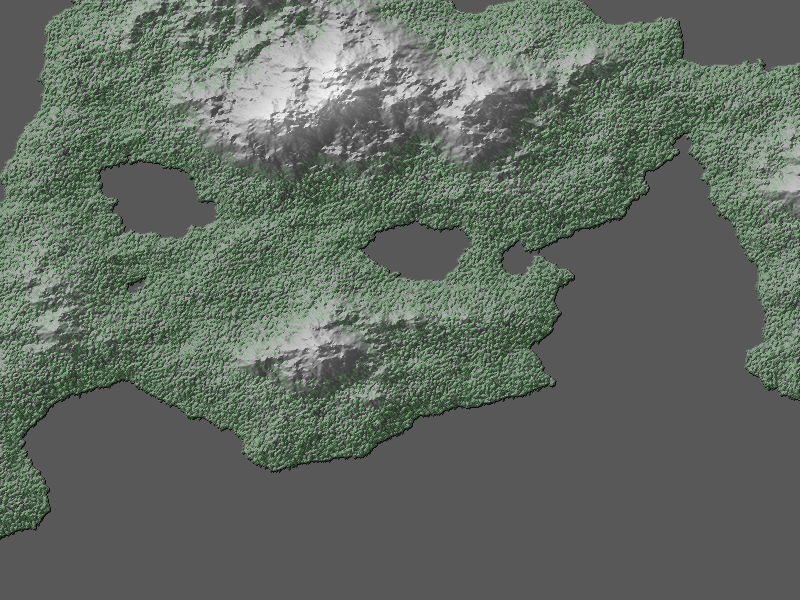

In [10]:
from functools import partial

from xrspatial.bump import bump

def heights(locations, src, src_range, height=20):
    num_bumps = locations.shape[0]
    out = np.zeros(num_bumps, dtype=np.uint16)
    for r in range(0, num_bumps):
        loc = locations[r]
        x = loc[0]
        y = loc[1]
        val = src[y, x]
        if val >= src_range[0] and val < src_range[1]:
            out[r] = height
    return out

T = 300000 # Number of trees to add per call
src = terrain.data
%time trees  = bump(W, H, count=T,    height_func=partial(heights, src=src, src_range=(1000, 1300), height=5))
trees       += bump(W, H, count=T//2, height_func=partial(heights, src=src, src_range=(1300, 1700), height=20))
trees       += bump(W, H, count=T//3, height_func=partial(heights, src=src, src_range=(1700, 2000), height=5))

tree_colorize = trees.copy()
tree_colorize.data[tree_colorize.data == 0] = np.nan
hillshade = dsgeo.hillshade(terrain + trees)

stack(shade(terrain,        cmap=['black', 'white'], how='linear'),
      shade(hillshade,      cmap=['black', 'white'], how='linear', alpha=128),
      shade(tree_colorize,  cmap='limegreen',        how='linear'))

## Mean
The `datashader.mean` function will smooth a given aggregate by using a 3x3 mean convolution filter. Optional parameters include `passes`, which is used to run the mean filter multiple times, and also `excludes` which are values that will not be modified by the mean filter.

We can use `mean` to add a coastal vignette to give out terrain scene a bit more character. Notice the water below now has a nice coastal gradient which adds some realism to our scene.

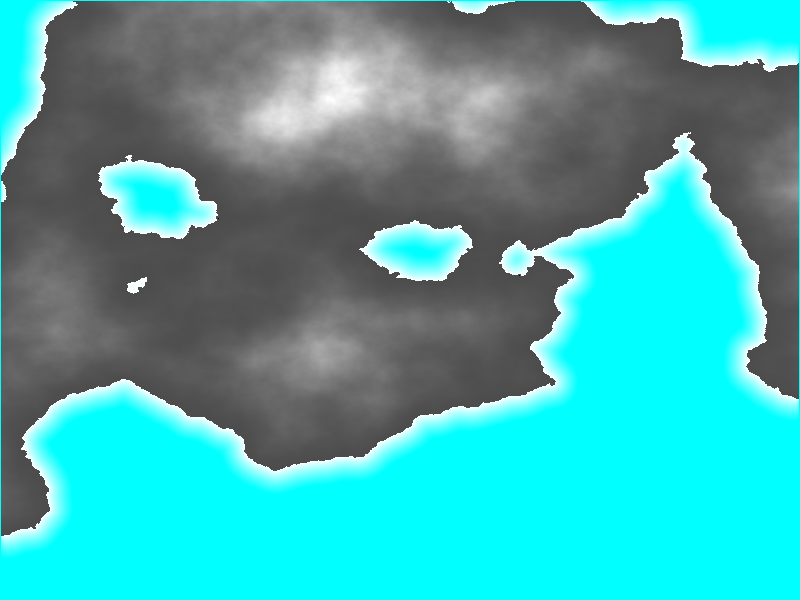

In [12]:
from xrspatial.focal import mean

LAND_CONSTANT = 50.0

water = terrain.copy()
water.data = np.where(water.data > 0, LAND_CONSTANT, 0)
water = mean(water, passes=50, excludes=[LAND_CONSTANT])
water.data[water.data == LAND_CONSTANT] = np.nan

stack(shade(terrain,    cmap=['black', 'white'], how='linear'),
      shade(water,      cmap=['aqua',  'white']))

## Full scene

We've now seen several of datashader's `geo` helper functions for working with elevation rasters.

Let's make a full archipelago scene by stacking `terrain`, `water`, `hillshade`, and `tree_colorize` together into one output image: 

In [13]:
stack(shade(terrain,       cmap=Elevation,          how='linear'),
      shade(water,         cmap=['aqua','white']),
      shade(hillshade(terrain + trees),   cmap=['black', 'white'], how='linear', alpha=128),
      shade(tree_colorize, cmap='limegreen',        how='linear'))

TypeError: 'DataArray' object is not callable

## Proximity

The `datashader.spatial.proximity` function operates on a given aggregate to produce a new distance aggregate based on target values and a distance metric. The values in the new aggregate will be the distance (according to the given metric) between each array cell (pixel) and the nearest target value in the source aggregate.

A powerful feature of `proximity` is that you can target specific values in the aggregate for distance calculation, while others are ignored.  Play with the `target_values` parameter below and see the difference of using `target_values=[1,2,3]` vs. `target_values=[2]` vs. `target_values=[3]`

   ##### Load data and create `ds.Canvas`

In [14]:
from datashader.spatial import proximity
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background

df = pd.DataFrame({
   'x': [-13, -11, -5,4, 9, 11, 18, 6],
   'y': [-13, -5, 0, 10, 7, 2, 5, -5]
})

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=(-20, 20), y_range=(-20, 20))

NameError: name 'pd' is not defined

   ##### Create Proximity Aggregate
   
   - Use `Canvas.points` to create an `xarray.DataArray`
   - Calculate proximity to nearest non-nan / non-zero elements using `datashader.spatial.proximity`

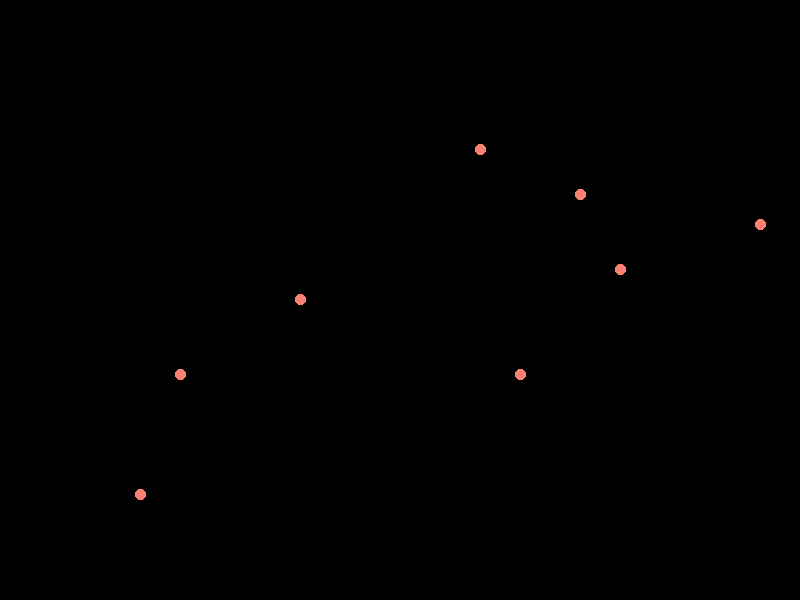

In [16]:
points_agg = cvs.points(df, x='x', y='y')
points_shaded = dynspread(shade(points_agg, cmap=['salmon',  'salmon']),
                          threshold=1,
                          max_px=5)
set_background(points_shaded, 'black')

##### Create proximity grid for all non-zero values

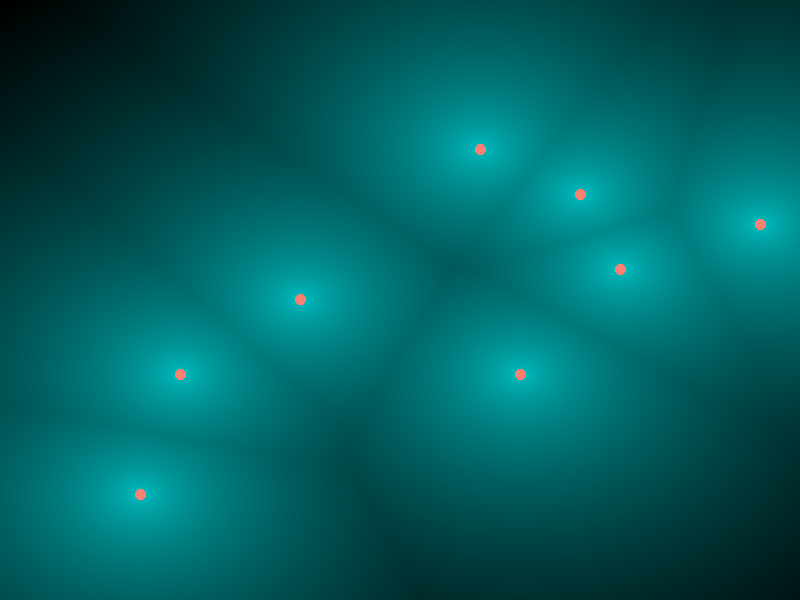

In [17]:
proximity_agg = proximity(points_agg)

stack(shade(proximity_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)

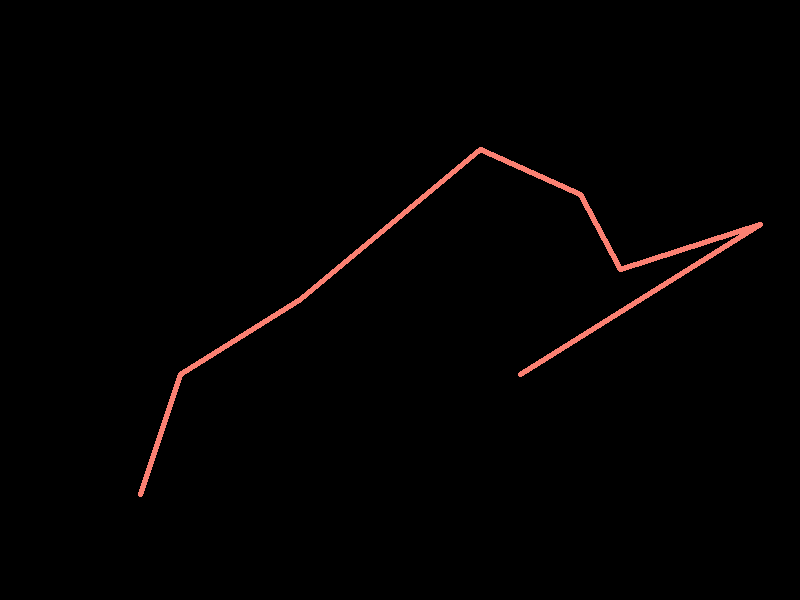

In [18]:
line_agg = cvs.line(df, x='x', y='y')
line_shaded = dynspread(shade(line_agg, cmap=['salmon',  'salmon']),
                          threshold=1,
                          max_px=2)
set_background(line_shaded, 'black')

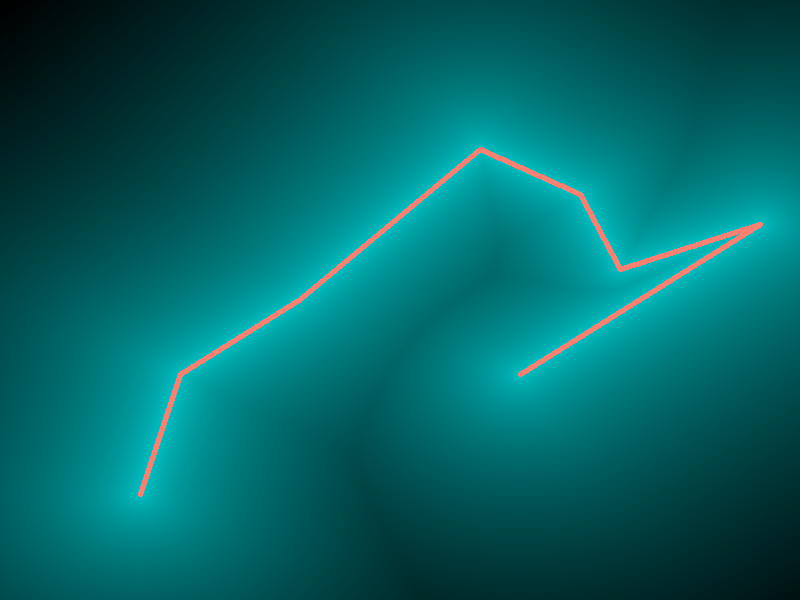

In [19]:
line_proximity = proximity(line_agg)
stack(shade(line_proximity, cmap=['darkturquoise', 'black'], how='linear'),
      line_shaded)

##### Transform Proximity DataArray
Like the other Datashader spatial tools, the result of `proximity` is an `xarray.DataArray` with a large API of potential transformations.

Below is an example of using `DataArray.where()` to apply a minimum distance and maximum distance.

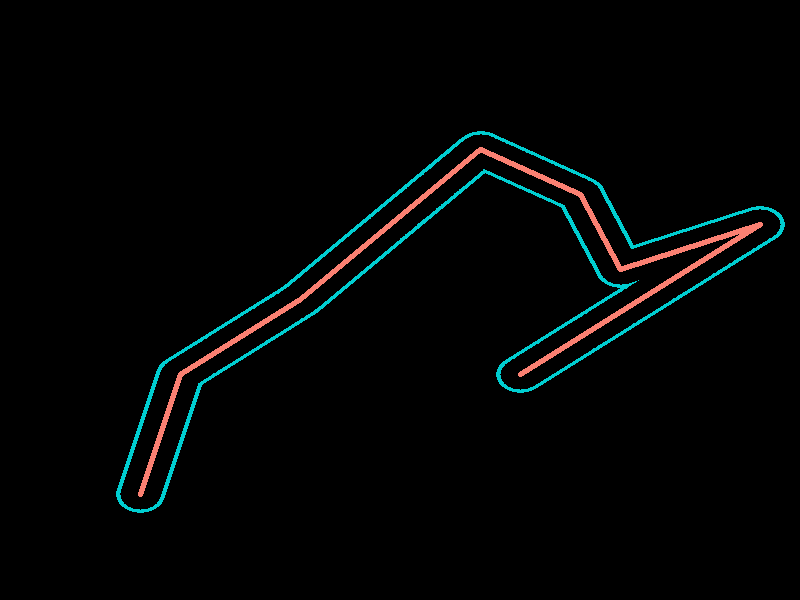

In [20]:
where_clause = (line_proximity > 1) & (line_proximity < 1.1)
proximity_shaded = shade(line_proximity.where(where_clause), cmap=['darkturquoise', 'darkturquoise'])
proximity_shaded = set_background(proximity_shaded, 'black')
stack(proximity_shaded, line_shaded)

## Viewshed

The `datashader.spatial.viewshed` function operates on a given aggregate to calculate the viewshed (the visible cells in the raster) for the given viewpoint (observer) location.  

The visibility model is the following: Two cells are visible to each other if the line of sight that connects their centers does not intersect the terrain. If the line of sight does not pass through the cell center, elevation is determined using bilinear interpolation.

##### Simple Viewshed Example

- The example below creates a datashader aggregate from a 2d normal distribution.
- To calculate the viewshed, we need an observer location.
- This location is indicated by the orange point in the upper-left of the plot.

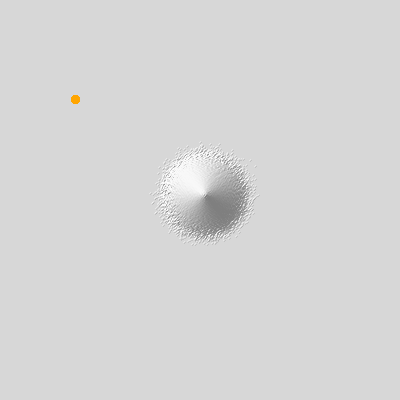

In [21]:
from datashader.spatial import proximity
from datashader.spatial import viewshed

from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background

OBSERVER_X = -12.5
OBSERVER_Y = 10

H = 400
W = 400

canvas = ds.Canvas(plot_width=W, plot_height=H,
                   x_range=(-20, 20), y_range=(-20, 20))

normal_df = pd.DataFrame({
   'x': np.random.normal(.5, 1, 10000000),
   'y': np.random.normal(.5, 1, 10000000)
})
normal_agg = canvas.points(normal_df, 'x', 'y')
normal_agg.values = normal_agg.values.astype("float64")
normal_shaded = shade(normal_agg)

observer_df = pd.DataFrame({'x': [OBSERVER_X], 'y': [OBSERVER_Y]})
observer_agg = canvas.points(observer_df, 'x', 'y')
observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

normal_illuminated = dsgeo.hillshade(normal_agg)
normal_illuminated_shaded = shade(normal_illuminated, cmap=['black', 'white'], 
                                  alpha=128, how='linear')

stack(normal_illuminated_shaded, observer_shaded)

##### Calculate viewshed using the observer location

CPU times: user 745 ms, sys: 80.3 ms, total: 825 ms
Wall time: 1.16 s


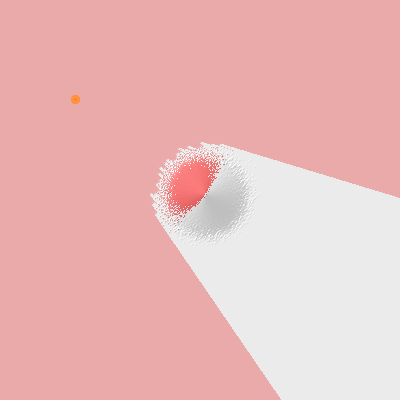

In [22]:
# Will take some time to run...
%time view = viewshed(normal_agg, x=OBSERVER_X, y=OBSERVER_Y)

view_shaded = shade(view, cmap=['white', 'red'], alpha=128, how='linear')

stack(normal_illuminated_shaded, observer_shaded, view_shaded)                         

##### Viewshed on Terrain

- Let's take the example above and apply it to our terrain aggregate.
- Notice the use of the `observer_elev` argument, which is the height of the observer above the terrain.

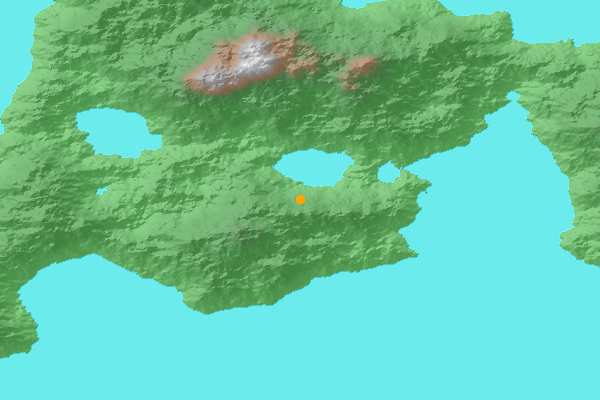

In [23]:
from datashader.spatial import viewshed

W = 600
H = 400

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = dsgeo.generate_terrain(cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = dsgeo.hillshade(terrain)

OBSERVER_X = 0.0
OBSERVER_Y = 0.0

observer_df = pd.DataFrame({'x': [OBSERVER_X],'y': [OBSERVER_Y]})
observer_agg = cvs.points(observer_df, 'x', 'y')
observer_shaded = dynspread(shade(observer_agg, cmap=['orange']),
                            threshold=1, max_px=4)

stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      observer_shaded)

In [35]:
%time view = viewshed(terrain, x=OBSERVER_X, y=OBSERVER_Y, observer_elev=100)

view_shaded = shade(view, cmap='fuchsia', how='linear')
stack(shade(illuminated, cmap=['black', 'white'], alpha=128, how='linear'),
      terrain_shaded,
      view_shaded,
      observer_shaded)

CPU times: user 1.37 s, sys: 190 ms, total: 1.56 s
Wall time: 2.17 s


TypeError: ufunc 'over' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

The fuchsia areas are those visible to an observer of the given height at the indicated orange location.

## Zonal Statistics

Zonal statistics allows for calculating summary statistics for specific areas or *zones* within a datashader aggregate. Zones are defined by creating an integer aggregate where the cell values are zone_ids.  The output of zonal statistics is a Pandas dataframe containing summary statistics for each zone based on a value raster.

Imagine the following scenario:
- You are a hiker on a six-day-trip.
- The path for each day is defined by a line segement.
- You wish to calculate the max and min elevations for each hiking segment as a Pandas dataframe based on an elevation dataset.

In [ ]:
from datashader.colors import Set1

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

terrain = dsgeo.generate_terrain(cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = dsgeo.hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

zone_df = pd.DataFrame({
   'x': [-11, -5, 4, 12, 14, 18, 19],
   'y': [-5, 4, 10, 13, 13, 13, 10],
   'trail_segement_id': [11, 12, 13, 14, 15, 16, 17]
})

zones_agg = cvs.line(zone_df, 'x', 'y', ds.sum('trail_segement_id'))
zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(np.int)
zones_shaded = dynspread(shade(zones_agg, cmap=Set1), max_px=5)

stack(illuminated_shaded, terrain_shaded, zones_shaded)

In [ ]:
from datashader.spatial.zonal import stats

stats(zones_agg, terrain)

##### Calculate custom stats for each zone

In [36]:
custom_stats = dict(elevation_change=lambda zone: zone.max() - zone.min(),
                    elevation_min=np.min,
                    elevation_max=np.max)

stats(zones_agg, terrain, custom_stats)

ValueError: cannot set a row with mismatched columns

Here the zones are defined by line segments, but they can be any spatial pattern, and in particular can be any region computable as a Datashader aggregate.


### References
- Burrough, P. A., and McDonell, R. A., 1998. Principles of Geographical Information Systems (Oxford University Press, New York), p. 406.
- Making Maps with Noise Functions: https://www.redblobgames.com/maps/terrain-from-noise/
- How Aspect Works: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA